In [1]:
# import dependencies
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

In [2]:
# read in previously collected data
schools = pd.read_csv("Data/fbsSchoolData.csv") # season, team, id, mascot, abbrev, conference, division
playCalls = pd.read_csv("Data/fbsPlayCallData.csv") # season, team, conference, totalPlays, passingPlays, rushingPlays
winLoss = pd.read_csv("Data/fbsWinLossData.csv") # season, team, id, mascot, abbrev, conference, division, games, wins, losses, ties

# merge datasets together
merge_1 = pd.merge(schools, playCalls, on = ["season", "team"], how = "left")
merge_2 = pd.merge(merge_1, winLoss, on = ["season", "id"], how = "left")

# preview dataset
merge_2.head()

,season,team_x,id,mascot_x,abbreviation_x,conference_x,division_x,conference_y,totalPlays,passingPlays,rushingPlays,team_y,mascot_y,abbreviation_y,conference,division_y,games,wins,losses,ties
0,2004,Air Force,2005,Falcons,AFA,Mountain West,NaN,Mountain West,147.0,33.0,110.0,Air Force,Falcons,AFA,Mountain West,NaN,11,5,6,0
1,2004,Akron,2006,Zips,AKR,Mid-American,East,Mid-American,131.0,70.0,55.0,Akron,Zips,AKR,Mid-American,East,11,6,5,0
2,2004,Alabama,333,Crimson Tide,ALA,SEC,West,SEC,677.0,224.0,434.0,Alabama,Crimson Tide,ALA,SEC,West,11,6,5,0
3,2004,Arizona,12,Wildcats,ARIZ,Pac-10,NaN,Pac-12,681.0,314.0,354.0,Arizona,Wildcats,ARIZ,Pac-10,NaN,11,3,8,0
4,2004,Arizona State,9,Sun Devils,ASU,Pac-10,NaN,Pac-12,823.0,429.0,370.0,Arizona State,Sun Devils,ASU,Pac-10,NaN,11,8,3,0


In [3]:
# subset the necessary columns and clean up data
playCalls = merge_2[["season", "id", "team_x", "conference_x", "totalPlays", "passingPlays", "rushingPlays", "games", "wins", "losses"]]

# rename column with suffix from merge
playCalls = playCalls.rename(columns = {"team_x": "team",
                                        "conference_x": "conference"})

# subset data for conferences we want
power5 = ["ACC", "Big Ten", "Big 12", "Pac-10", "Pac-12", "SEC"]
playCalls = playCalls[playCalls["conference"].isin(power5)]

# drop NA values
playCalls = playCalls.dropna()

# preview the dataset
playCalls.head(10)

,season,id,team,conference,totalPlays,passingPlays,rushingPlays,games,wins,losses
2,2004,333,Alabama,SEC,677.0,224.0,434.0,11,6,5
3,2004,12,Arizona,Pac-10,681.0,314.0,354.0,11,3,8
4,2004,9,Arizona State,Pac-10,823.0,429.0,370.0,11,8,3
5,2004,8,Arkansas,SEC,699.0,279.0,406.0,11,5,6
8,2004,2,Auburn,SEC,753.0,279.0,452.0,12,12,0
10,2004,239,Baylor,Big 12,720.0,385.0,319.0,11,3,8
16,2004,25,California,Pac-10,790.0,308.0,453.0,11,10,1
19,2004,228,Clemson,ACC,639.0,328.0,296.0,11,6,5
20,2004,38,Colorado,Big 12,777.0,379.0,378.0,12,7,5
23,2004,150,Duke,ACC,617.0,284.0,317.0,11,2,9


In [4]:
# identifying quartile ranges for each season to check for incomplete/incorrect play totals
lowOutliers = pd.DataFrame(columns = ["season", "team", "totalPlays"])
highOutliers = pd.DataFrame(columns = ["season", "team", "totalPlays"])

for season in playCalls["season"].unique():
    currSeason = playCalls["totalPlays"].loc[playCalls["season"] == season]
    quartiles = currSeason.quantile([.25,.5,.75])
    
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)

    # append to a dataframe of team-season-total plays that includes all datapoints below lower_bound
    subset = playCalls.loc[playCalls["season"] == season]
    
    sznLowOutliers = subset.loc[subset["totalPlays"] <= lower_bound]
    sznHighOutliers = subset.loc[subset["totalPlays"] >= upper_bound]
    
    lowOutliers = lowOutliers.append(sznLowOutliers, sort = False)
    highOutliers = highOutliers.append(sznHighOutliers, sort = False)
    
# preview sets of potential outliers
print(lowOutliers[["season", "team", "totalPlays"]])
print("")
print(highOutliers[["season", "team", "totalPlays"]])

### without checking each team + season datapoint individually against public sources, it's not clear which
### low outliers are incomplete. given the size of the dataset, we believe the safest move is to discard
### those data points.

# removing low outliers
playCallsClean = playCalls[~playCalls.isin(lowOutliers)].dropna()

# check that outlier removal worked
print("")
print(f"There were {len(lowOutliers)} low outliers. The previous number of rows in the DF is {len(playCalls)}. \
The new number of rows in the DF is {len(playCallsClean)}.")

     season              team  totalPlays
161    2005      Kansas State       371.0
249    2006            Baylor       473.0
381    2007              Duke       533.0
712    2009  Washington State       646.0
1467   2016           Arizona       666.0
1503   2016          Illinois       703.0

     season          team  totalPlays
551    2008      Oklahoma      1000.0
667    2009  Northwestern       998.0
692    2009         Texas       995.0
693    2009     Texas A&M       995.0
791    2010      Oklahoma      1136.0
814    2010    Texas Tech       992.0
1211   2014       Arizona      1141.0
1356   2015       Clemson      1197.0
1484   2016       Clemson      1191.0

There were 6 low outliers. The previous number of rows in the DF is 962. The new number of rows in the DF is 956.


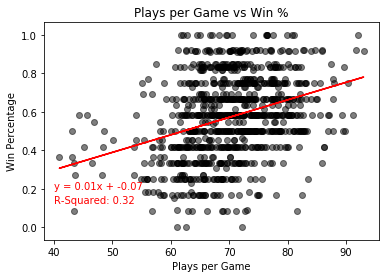

In [5]:
# Create column for win %
playCallsClean["winPct"] = playCallsClean["wins"] / playCallsClean["games"]

# Scale play totals to number of games
playCallsClean["playsPerGame"] = playCallsClean["totalPlays"] / playCallsClean["games"]

# regress Plays per Game against Win %
x_values = playCallsClean["playsPerGame"]
y_values = playCallsClean["winPct"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

# plot Plays per Game against Win %
plt.scatter(playCallsClean["playsPerGame"], playCallsClean["winPct"], color = "black", alpha = 0.5)
plt.plot(x_values, regress_values, color = "red")
plt.annotate(line_eq, (40, 0.2), fontsize = 10, color = "red")
plt.annotate(f"R-Squared: {round(rvalue, 2)}", (40, 0.125), fontsize = 10, color = "red")
plt.title("Plays per Game vs Win %")
plt.xlabel("Plays per Game")
plt.ylabel("Win Percentage")
plt.show()

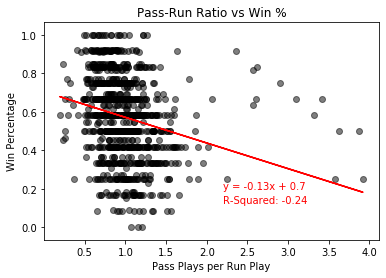

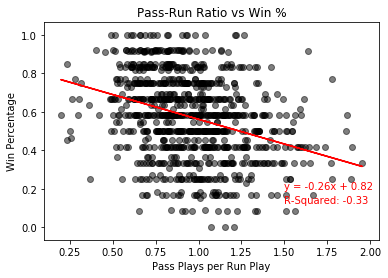

In [12]:
# Create column for pass/run ratio
playCallsClean["passRunRatio"] = playCallsClean["passingPlays"] / playCallsClean["rushingPlays"]

# regress Plays per Game against Win %
x_values = playCallsClean["passRunRatio"]
y_values = playCallsClean["winPct"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

# plot Plays per Game against Win %
plt.scatter(playCallsClean["passRunRatio"], playCallsClean["winPct"], color = "black", alpha = 0.5)
plt.plot(x_values, regress_values, color = "red")
plt.annotate(line_eq, (2.2, 0.2), fontsize = 10, color = "red")
plt.annotate(f"R-Squared: {round(rvalue, 2)}", (2.2, 0.125), fontsize = 10, color = "red")
plt.title("Pass-Run Ratio vs Win %")
plt.xlabel("Pass Plays per Run Play")
plt.ylabel("Win Percentage")
plt.show()

# Recreate plot removing teams with more than 2 passes per run
plot_subset = playCallsClean.loc[playCallsClean["passRunRatio"] <= 2]

# regress Plays per Game against Win %
x_values = plot_subset["passRunRatio"]
y_values = plot_subset["winPct"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

# plot Plays per Game against Win %
plt.scatter(plot_subset["passRunRatio"], plot_subset["winPct"], color = "black", alpha = 0.5)
plt.plot(x_values, regress_values, color = "red")
plt.annotate(line_eq, (1.5, 0.2), fontsize = 10, color = "red")
plt.annotate(f"R-Squared: {round(rvalue, 2)}", (1.5, 0.125), fontsize = 10, color = "red")
plt.title("Pass-Run Ratio vs Win %")
plt.xlabel("Pass Plays per Run Play")
plt.ylabel("Win Percentage")
plt.show()